# Intro TensorFlow avec tf.keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thalitadruCoursNNDL/blob/master/TFKerasIntro.ipynb)

tf.keras est l'API haut-niveau par défaut de Tensorflow. Pour la plupart des projets, elle sera souvent suffisante pour exprimer vos modèles, avec l'avantage d'éliminer pas mal de code répétitif "boiler-plate" avec pas mal d'abstractions sur les solveurs d'optimisation (`optimisers`) et sur boucles d'entraînement et validation (`model.fit()` et `model.evaluate()`).
Il s'agit en plus d'une API bien documentée et réputée pour sa facilité de prise en main.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, losses, optimizers

SEED = 0
np.random.seed(SEED)
rng = np.random.RandomState(SEED)
tf.random.get_global_generator().reset_from_seed(SEED)
tfseed = tf.random.get_global_generator().reset_from_seed

## Modèle `Sequential `

Avec `tf.keras.Sequential` on peut construire des modèles par empilement de couches (`layers`). Elle est adapté à tout modèle qui reçoit un seul tenseur en entrée et renvoie un unique tenseur en sortie.

In [2]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Input(shape=(8,)),
        keras.layers.Dense(
            units=4,
            activation="relu",
            name="layer1",
        ),
        keras.layers.Dense(
            3,
            activation="relu",
            name="layer2",
        ),
        keras.layers.Dense(
            1,
            name="layer3",
        ),
    ]
)
model

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 4)                 36        
_________________________________________________________________
layer2 (Dense)               (None, 3)                 15        
_________________________________________________________________
layer3 (Dense)               (None, 1)                 4         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


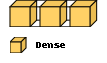

In [4]:
import visualkeras as vk

vk.layered_view(model, legend=True)

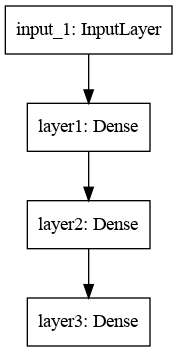

In [5]:
keras.utils.plot_model(model)

In [6]:
x = tf.reshape(tf.range(0, 16), shape=(2, -1))
x

<tf.Tensor: shape=(2, 8), dtype=int32, numpy=
array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15]], dtype=int32)>

In [7]:
y = model(x)
y

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 2.5849366 ],
       [-0.45303398]], dtype=float32)>

Un modèle `Sequential` n'est pas approprié si:

- Votre modèle (ou une de ses couches) a plusieurs entrées et ou sorties
- Vous désirez partager des poids entre des couches (_layer sharing_)
- Vous souhaitez une topologie non-linéaire (connections qui sautent des couches comme dans les ResNets ou chemins parallèles comme dans les Inception)

Vous devez alors faire appel à l'API fonctionnelle.

### Parenthese: Controle de l'initialization
Afin de pouvoir réproduire les mêmes résultats, je redéclare le modèle ici en precisant la seed et le mode d'initialisation utilisé pour chaque couche.

In [8]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Input(shape=(8,)),
        layers.BatchNormalization(),
        keras.layers.Dense(
            units=4,
            activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
            name="layer1",
        ),
        keras.layers.Dense(
            3,
            activation="relu",
            kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
            name="layer2",
        ),
        keras.layers.Dense(
            1,
            kernel_initializer=tf.keras.initializers.GlorotNormal(seed=SEED),
            name="layer3",
        ),
    ]
)
model

## Avant l'entrainement: `compile`

Avant pouvoir appeler `fit`, il faut effectuer l'étape `compile`.
Pour cela on doit choisir une fonction de cout `loss`

De plus, on peut aussi choisir:
- `optimizer`: un algorithme de descente du gradient: SGD, Adam, RMSprop, etc., et son taux d'apprentissage `learning_rate`
- `metrics`: des métriques additionnelles à calculer

Si on n'informe rien, des valeurs par défaut seront utilisées.

In [9]:
model.compile(
    optimizer=optimizers.Adagrad(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
)

## Fit

### Exemple : NN sur California Housing data
 Le modèle qu'on vient de crèer :
 - prends 8 attributs en entrée
 - renvoi une valuer réele en sortie
 
Il correspond aux dimensions du dataset CaliforniaHousing que vous avez utilisé lors du TD précédent.
Chargez ce dataset ici et entraînez ce modèle à l'aide de sa méthode `fit`.
Donnez en entrée :
- les données `X`,
- les targets `y`,
- un nombre d'époques `epochs`,
- et choisissez une fraction des données pour le `validation_split`.


In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [11]:
# chargez le dataset ici
# fetch_california_housing
d = fetch_california_housing()
X, y = d.data, d.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

In [12]:
## completez l'appel a fit
out = model.fit(
    X_train,
    y=y_train,
    epochs=5,
    batch_size=1,
    validation_split=0.1,
)

Epoch 1/5
13932/13932 [==============================] - 9s 659us/step - loss: 5.3027 - val_loss: 59765804.0000
Epoch 2/5
13932/13932 [==============================] - 9s 656us/step - loss: 4.8300 - val_loss: 63357392.0000
Epoch 3/5
13932/13932 [==============================] - 9s 648us/step - loss: 4.5319 - val_loss: 77080832.0000
Epoch 4/5
13932/13932 [==============================] - 10s 682us/step - loss: 4.3987 - val_loss: 64142624.0000
Epoch 5/5
13932/13932 [==============================] - 8s 600us/step - loss: 4.1085 - val_loss: 70874048.0000


In [13]:
# ??model1.fit

### `History` de l'entraînement

L'appel de `fit` renvoie une structure contenant les valeurs des métriques au cours de l'entraînement.

In [14]:
out.history.keys()

dict_keys(['loss', 'val_loss'])

In [15]:
out.history["loss"][-5:-1]

[5.112608909606934, 4.70013427734375, 4.451781272888184, 4.2615156173706055]

In [16]:
out.history["val_loss"][-5:-1]

[59765804.0, 63357392.0, 77080832.0, 64142624.0]

In [17]:
model.fit

<bound method Model.fit of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc1f9fcad60>>

## Evaluate
Regardons le score de notre modèle sur l'ensemble complet d'entraînement et sur celui de test

In [18]:
model.evaluate(X_train, y_train)

484/484 [==============================] - 0s 777us/step - loss: 70537008.0000


70537008.0

In [19]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 849us/step - loss: 69710224.0000


69710224.0

## Courbes d'apprentissage

Ces courbes sauvegardes dans `history` son des courbes d'apprentissage.
On peut les afficher dans un graphique ainsi:

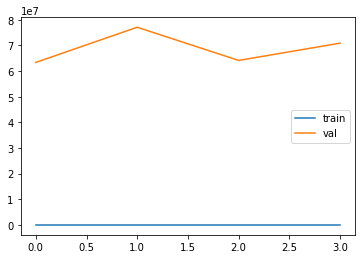

In [20]:
plt.plot(out.history["loss"][1:], label="train")
plt.plot(out.history["val_loss"][1:], label="val")
plt.legend()

### Courbes d'apprentissage et early stopping
Les courbes d'apprentissage servent a suivre l'entraînement du modèle et voir le moment ou il a donnée le meilleurs score en validation (et donc son meilleur potentiel de généralisation). Meme si l'erreur en validation commence à augmenter en fin d'entrainement, il suffit de sauvegarder des checkpoints du modèle sur le époques ou ce, on peut a la fin reprendre le modèle quand le `val_loss` était le plus bas.

## Partial fit
Sans réinitialiser le modèle, chaque appel à fit continue l'entraînement du réseau pour le nombre d'époques spécifié.
Chaque appel réalise donc un fitting partiel.

In [21]:
model.optimizer.learning_rate = 0.1
out2 = model.fit(
    X,
    y=y,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
)

Epoch 1/10
258/258 [==============================] - 0s 1ms/step - loss: 3.6993 - val_loss: 4.5353
Epoch 2/10
258/258 [==============================] - 0s 1ms/step - loss: 3.4822 - val_loss: 4.3015
Epoch 3/10
258/258 [==============================] - 0s 1ms/step - loss: 3.2899 - val_loss: 4.0870
Epoch 4/10
258/258 [==============================] - 0s 1ms/step - loss: 3.1146 - val_loss: 3.8900
Epoch 5/10
258/258 [==============================] - 0s 1ms/step - loss: 2.9548 - val_loss: 3.7092
Epoch 6/10
258/258 [==============================] - 0s 1ms/step - loss: 2.8091 - val_loss: 3.5432
Epoch 7/10
258/258 [==============================] - 0s 1ms/step - loss: 2.6762 - val_loss: 3.3905
Epoch 8/10
258/258 [==============================] - 0s 1ms/step - loss: 2.5550 - val_loss: 3.2502
Epoch 9/10
258/258 [==============================] - 0s 1ms/step - loss: 2.4444 - val_loss: 3.1211
Epoch 10/10
258/258 [==============================] - 0s 1ms/step - loss: 2.3436 - val_loss: 3.0024

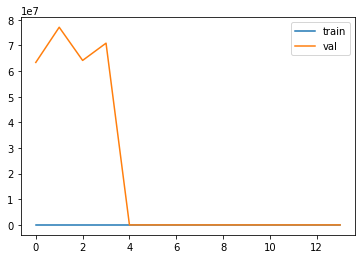

In [22]:
plt.plot(out.history["loss"][1:] + out2.history["loss"], label="train")
plt.plot(out.history["val_loss"][1:] + out2.history["loss"], label="val")
plt.legend()

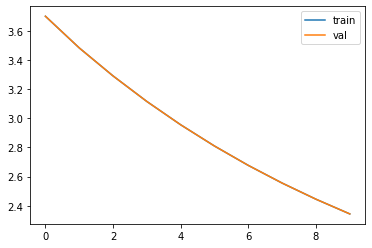

In [23]:
plt.plot(out2.history["loss"], label="train")
plt.plot(out2.history["loss"], label="val")
plt.legend()

### Exercice
Évaluez le modèle sur train et test une nouvelle fois. Est-ce que sa généralisation a amélioré?

## Callbacks

In [24]:
?tf.keras.callbacks.EarlyStopping

Init signature:
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)
Docstring:     
Stop training when a monitored metric has stopped improving.

Assuming the goal of a training is to minimize the loss. With this, the
metric to be monitored would be `'loss'`, and mode would be `'min'`. A
`model.fit()` training loop will check at end of every epoch whether
the loss is no longer decreasing, considering the `min_delta` and
`patience` if applicable. Once it's found no longer decreasing,
`model.stop_training` is marked True and the training terminates.

The quantity to be monitored needs to be available in `logs` dict.
To make it so, pass the loss or metrics at `model.compile()`.

Arguments:
  monitor: Quantity to be monitored.
  min_delta: Minimum change in the monitored quantity
      to qualify as an improvement, i.e. an absolute
      change of less than min_delta,

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

In [26]:
?tf.keras.callbacks.ReduceLROnPlateau

Init signature:
tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
    **kwargs,
)
Docstring:     
Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor
of 2-10 once learning stagnates. This callback monitors a
quantity and if no improvement is seen for a 'patience' number
of epochs, the learning rate is reduced.

Example:

```python
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model.fit(X_train, Y_train, callbacks=[reduce_lr])
```

Arguments:
    monitor: quantity to be monitored.
    factor: factor by which the learning rate will be reduced.
      `new_lr = lr * factor`.
    patience: number of epochs with no improvement after which learning rate
      will be reduced.
    verbose: int. 0: quiet, 1: update messages.
 

In [27]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001,
)

In [28]:
nan_stop = tf.keras.callbacks.TerminateOnNaN()

In [29]:
callbacks = [
    early_stop,
    reduce_lr,
    nan_stop,
]

In [30]:
model.optimizer.learning_rate = 0.5
out2 = model.fit(
    X,
    y=y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=0,
    callbacks=callbacks,
)

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


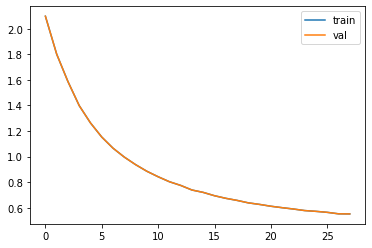

In [31]:
plt.plot(out2.history["loss"], label="train")
plt.plot(out2.history["loss"], label="val")
plt.legend()

### Exercice
Évaluez le modèle sur train et test une nouvelle fois. Est-ce que sa généralisation a amélioré?